In the following I use a simple convolutional neural network to classify apparel from the fashion-MNIST dataset. I'm curious to see how well it works compared to the conventional MNIST dataset!

https://github.com/zalandoresearch/fashion-mnist

In [1]:
import numpy as np
import pandas as pd
import os
import time
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# import data
training_set = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
test_set = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

In [3]:
# For each entry of the dataset, there is a label as well as a value for each pixel in the image (28x28 pixels)
# test_set is similar
training_set.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [4]:
# creating a dictionary to help convert the integer labels into what they respresent for future use
label_names ={0:'top', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'ankle boot'}

In [5]:
# split into train/valid
train_features, valid_features, train_labels, valid_labels = train_test_split(training_set[list(training_set.columns)[1:]], training_set['label'], test_size = .15)
# split test set into features and labels 
test_features = test_set[list(test_set.columns)[1:]]
test_labels = test_set['label']

In [6]:
# reshaping the features so that the pixel values are arranged according to their place
# converting to np arrays for use in model
num_col = 28
num_row = 28
train_features = np.array(train_features).reshape(train_features.shape[0], num_row, num_col, 1)
valid_features = np.array(valid_features).reshape(valid_features.shape[0], num_row, num_col, 1)
test_features = np.array(test_features).reshape(test_features.shape[0], num_row, num_col, 1)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

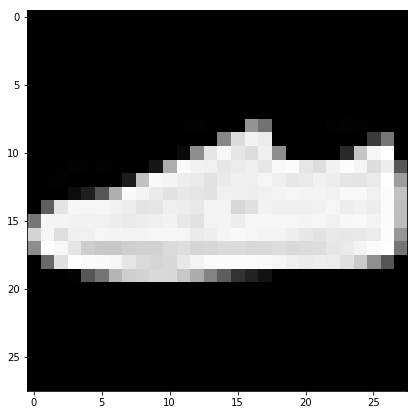

sneaker


In [7]:
# we can build images from the data using the pixel values
example_image = train_features[0].reshape(28,28)
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
example = ax.imshow(example_image, cmap = cm.Greys_r, interpolation = 'none')    
plt.show()
# show the label for the image
print(label_names[train_labels[0]])

# while the image isn't the best, and this certainly isn't the best way to generate it, it's vaguely clear what the item is

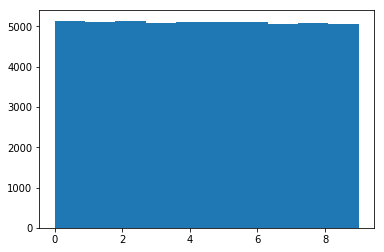

In [8]:
# checking if there's a class imbalance, turns out all classes have about equal representation
plt.hist(train_labels)
plt.show()

In [9]:
# some final processing to normalize the pixel values to [0,1], and labels to appropiate categorical format 
train_features = train_features / 255
valid_features = valid_features / 255
test_features = test_features / 255

train_labels = to_categorical(train_labels)
valid_labels = to_categorical(valid_labels)
test_labels = to_categorical(test_labels)

In [10]:
train_labels.shape

(51000, 10)

Done with the initial data processing, moving onto building the model!
Tensorflow with keras API is used. 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
import tensorflow as tf

Below are most of the hyperparameters that are used for tuning (along with some constants such as input shape).
Some observations:
Dropout probability (prob_drop) has to be carefully set to prevent the model from overfitting too much while still learning well. .4 works pretty well.
Smaller pool size tends to slow the learning rate significantly. Simply halving (2,2) seems best. 
Having 2 convolution layers and 2 fully connected layers has best performance. Similar performance could probably be had using more (and maybe fewer) layers with other hyperparameters changed. 
32 filters tends to work well for the 


In [12]:
input_shape = (28,28,1)
prob_drop = .3 # usually good around .2 - .4
pool_size = (2,2)
classes = 10
epochs = 20 # usually converges around 10-15
batch_size = 100 
max_conv_layers = 2 # best 2
max_fc_layers = 2 # best 2
first_layer_filters = 32 # 32 works well
filters = 64 # 32 works well, more doesn't improve results
dense_units = 512
kernel_size = 3

In [13]:
## using the keras sequential model for the CNN
model = Sequential()

# input layer/convolutional layer 1

# convolutional layers convert the original matrix of values into another matrix representing different parts of the image.
# as the model learns, it will get better as converting parts of the image into useful values
model.add(Convolution2D(filters = first_layer_filters, kernel_size = kernel_size, strides = 1, activation='relu', 
                        input_shape=input_shape, padding = 'same'))

# pooling helps make the model more efficient by reducing the size of the representation outputted by the Convolution2D portion
model.add(MaxPooling2D(pool_size=pool_size, padding = 'same', strides=(2,2)))

#lower the dimension before passing to fully connected layers, if this is the last layer
if max_conv_layers == 1:
    model.add(Flatten())
# dropout layers cause random connections to be dropped at each training step. This helps prevent the model from overfitting
model.add(Dropout(rate = prob_drop))

# add more convolutional layers
for conv_layer in range(max_conv_layers - 1):
    model.add(Convolution2D(filters = filters, kernel_size = kernel_size, strides = 1, activation = 'relu', padding = 'same'))
    #model.add(MaxPooling2D(pool_size = pool_size, padding = 'same', strides=(2,2)))
    # for the last convolutional layer, lower the dimension before passing to fully connected layers
    if conv_layer == (max_conv_layers - 2):
        model.add(Flatten())
    model.add(Dropout(rate = prob_drop))
    
# add some fully connected layers for the end steps of the model
for fc_layer in range(max_fc_layers - 1):
    # a simple dense neural network
    model.add(Dense(dense_units, activation = 'relu'))
    # dropout layer to prevent overfitting
    model.add(Dropout(rate = prob_drop))

# final classification layer (uses softmax to output values for each of the 10 classes)
model.add(Dense(classes, activation = 'softmax'))

# simple summary of the model
model.summary()

opt = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dropout_1 (Dropout)  

In [14]:
history = model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size, validation_data = (valid_features, valid_labels), shuffle = True)

Train on 51000 samples, validate on 9000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
51000/51000 [==============================] - 9s 180us/sample - loss: 0.4769 - acc: 0.8285 - val_loss: 0.3178 - val_acc: 0.8854
Epoch 2/20
51000/51000 [==============================] - 8s 152us/sample - loss: 0.3063 - acc: 0.8891 - val_loss: 0.2595 - val_acc: 0.9079
Epoch 3/20
51000/51000 [==============================] - 8s 151us/sample - loss: 0.2659 - acc: 0.9045 - val_loss: 0.2334 - val_acc: 0.9170
Epoch 4/20
51000/51000 [==============================] - 8s 151us/sample - loss: 0.2451 - acc: 0.9119 - val_loss: 0.2427 - val_acc: 0.9124
Epoch 5/20
51000/51000 [==============================] - 8s 151us/sample - loss: 0.2277 - acc: 0.9170 - val_loss: 0.2353 - val_acc: 0.9191
Epoch 6/20
51000/51000 [==============================] - 8s 151us/sample - loss: 0.2205 - acc: 0.9213 - val_loss: 0.2271 - val_acc: 0.9211
Epoch 7/20
51000/51000 [==============================] - 8s 15

After finding sufficiently good hyperparameters, the model is retrained using all the train and validation data. 

In [15]:
features = np.vstack((train_features, valid_features))
labels = np.vstack((train_labels, valid_labels))

In [16]:
## using the keras sequential model for the CNN
model = Sequential()

# input layer/convolutional layer 1

# convolutional layers convert the original matrix of values into another matrix representing different parts of the image.
# as the model learns, it will get better as converting parts of the image into useful values
model.add(Convolution2D(filters = first_layer_filters, kernel_size = kernel_size, strides = 1, activation='relu', 
                        input_shape=input_shape, padding = 'same'))

# pooling helps make the model more efficient by reducing the size of the representation outputted by the Convolution2D portion
model.add(MaxPooling2D(pool_size=pool_size, padding = 'same', strides=(2,2)))

#lower the dimension before passing to fully connected layers, if this is the last layer
if max_conv_layers == 1:
    model.add(Flatten())
# dropout layers cause random connections to be dropped at each training step. This helps prevent the model from overfitting
model.add(Dropout(rate = prob_drop))

# add more convolutional layers
for conv_layer in range(max_conv_layers - 1):
    model.add(Convolution2D(filters = filters, kernel_size = kernel_size, strides = 1, activation = 'relu', padding = 'same'))
    #model.add(MaxPooling2D(pool_size = pool_size, padding = 'same', strides=(2,2)))
    # for the last convolutional layer, lower the dimension before passing to fully connected layers
    if conv_layer == (max_conv_layers - 2):
        model.add(Flatten())
    model.add(Dropout(rate = prob_drop))
    
# add some fully connected layers for the end steps of the model
for fc_layer in range(max_fc_layers - 1):
    # a simple dense neural network
    model.add(Dense(dense_units, activation = 'relu'))
    # dropout layer to prevent overfitting
    model.add(Dropout(rate = prob_drop))

# final classification layer (uses softmax to output values for each of the 10 classes)
model.add(Dense(classes, activation = 'softmax'))

# simple summary of the model
model.summary()

opt = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               6423040   
__________

In [17]:
history = model.fit(features, labels, epochs = epochs, batch_size = batch_size, validation_data = (test_features, test_labels), shuffle = True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 158us/sample - loss: 0.4497 - acc: 0.8378 - val_loss: 0.3199 - val_acc: 0.8849
Epoch 2/20
60000/60000 [==============================] - 9s 152us/sample - loss: 0.2944 - acc: 0.8934 - val_loss: 0.2595 - val_acc: 0.9101
Epoch 3/20
60000/60000 [==============================] - 9s 152us/sample - loss: 0.2557 - acc: 0.9072 - val_loss: 0.2446 - val_acc: 0.9129
Epoch 4/20
60000/60000 [==============================] - 9s 152us/sample - loss: 0.2373 - acc: 0.9135 - val_loss: 0.2335 - val_acc: 0.9218
Epoch 5/20
60000/60000 [==============================] - 9s 152us/sample - loss: 0.2240 - acc: 0.9201 - val_loss: 0.2120 - val_acc: 0.9255
Epoch 6/20
60000/60000 [==============================] - 9s 152us/sample - loss: 0.2180 - acc: 0.9230 - val_loss: 0.2300 - val_acc: 0.9274
Epoch 7/20
60000/60000 [==============================] - 9s 151us/sample - loss: 0.2153 - acc: 0.9241 - val_l

In [18]:
# final evaluation using the test data
model.evaluate(test_features, test_labels)

10000/10000 [==============================] - 1s 74us/sample - loss: 0.3204 - acc: 0.9158


[0.32038994684219363, 0.9158]

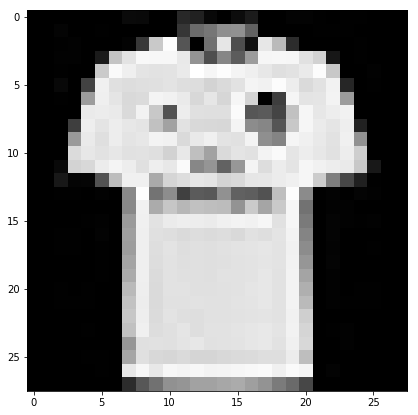

Predicted label: top
Actual label: top


In [19]:
# quick example classification
example_image = test_features[0].reshape(28,28)
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
example = ax.imshow(example_image, cmap = cm.Greys_r, interpolation = 'none')    
plt.show()
print('Predicted label: ' + str(label_names[np.argmax(model.predict(test_features)[0])]))
print('Actual label: ' + str(label_names[np.argmax(test_labels[0])]))